In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import curve_fit

default_col_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def model_LV_comp(state, t, params):
    r1, r2, c11, c12, c21, c22 = params
    x, y = state
    dx_dt = x * (r1 - c11*x - c12*y)
    dy_dt = y * (r2 - c21*x + c22*x)
    return np.array([dx_dt, dy_dt])

def solver_LV_comp(state, t, *params): 
    return odeint(model_LV, state, t, args = params, atol=1e-8, rtol=1e-11)


def model_LV(state, t, params):
    r1, r2, c12, c21 = params
    x, y = state
    dx_dt = x * ( r1 - c12 * y)
    dy_dt = y * (-r2 + c21 * x)
    return np.array([dx_dt, dy_dt])

def solver_LV(state, t, *params): 
    return odeint(model_LV, state, t, args = params, atol=1e-8, rtol=1e-11)

In [4]:
# r1, r2, c11, c12, c21, c22 = 1, .1, .5, 1, 2, .5
# params = [r1, r2, c11, c12, c21, c22]
r1, r2, c12, c21 = 0.5, 0.8, 0.025, 0.025
params = [r1, r2, c12, c21]
t_max = 40

x0, y0 = 40, 10
state_0 = [x0, y0]

t = np.linspace(0, t_max, 1000)

res = solver_LV(state_0, t, tuple(params))

plt.plot(t, res, label=["Prey (x)", "Predatory (y)"])
plt.legend()
plt.ylim(bottom=0)
plt.title("Lotka-Voltera");

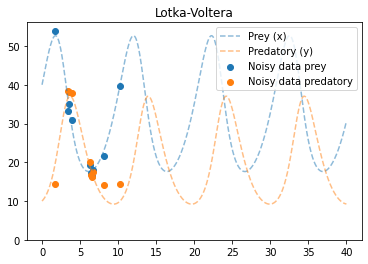

In [5]:
# Generate data
nbr_data = 10
# t_samples = np.random.uniform(0, t_max/3, nbr_data)
t_samples = np.random.choice((t[:len(t)//3]), nbr_data, replace=False)
t_samples.sort()
idxs = np.where(np.isin(t, t_samples))[0]
data = res[idxs, :]
# data = solver_LV(state_0, t_samples, tuple(params))

mu1, mu2, sigma1, sigma2 = 0, 0, 1, 2

# Add Gaussian noise to each column independently
data_noisy = np.column_stack([
    data[:, 0] + np.random.normal(mu1, sigma1, data.shape[0]),
    data[:, 1] + np.random.normal(mu2, sigma2, data.shape[0])
])

# plt.figure(figsize=(12, 8))
plt.plot(t, res, '--', alpha=.5, label=["Prey (x)", "Predatory (y)"])
# plt.scatter(t_samples, data[:, 0], alpha=.3)
# plt.scatter(t_samples, data[:, 1], alpha=.3)
plt.scatter(t_samples, data_noisy[:, 0], color=default_col_pal[0], label="Noisy data prey")
plt.scatter(t_samples, data_noisy[:, 1], color=default_col_pal[1], label="Noisy data predatory")
plt.legend()
plt.ylim(bottom=0)
plt.title("Lotka-Voltera");

x0 = Initial number of prey =          44.56        (true value = 40.00)
y0 = Initial number of predatories =   15.19        (true value = 10.00)
r1 = Growth rate for prey =            0.432        (true value = 0.50)
r2 = Decay rate for predatory =        1.150        (true value = 0.80)
c12 = Effect of predatory on prey =    0.021        (true value = 0.03)
c21 = Effect of prey on predatory =    0.039        (true value = 0.03)


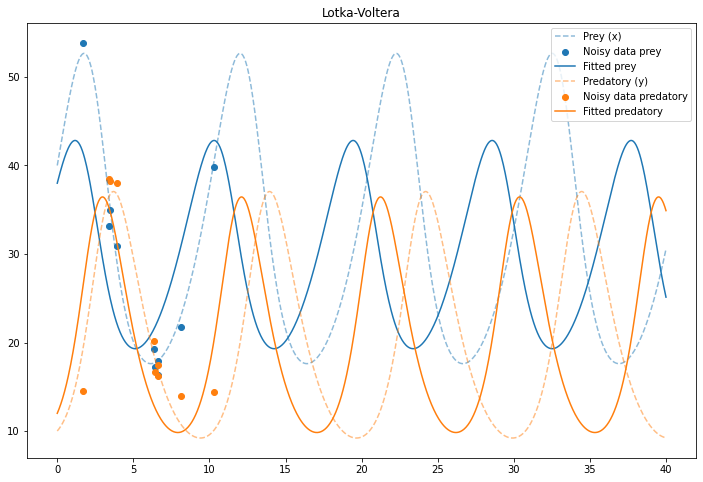

In [7]:
def integration_LV(state_arr, *params):
    
    # /!\ WE WILL USE t_samples WHICH IS DEFINED OUT OF THE FUNCTION

    r1_ini, r2_ini, c12_ini, c21_ini, x_0, y_0 = params
    state_0 = [x_0, y_0]
    params_LV = [r1_ini, r2_ini, c12_ini, c21_ini]
    T = t_samples
    res0 = solver_LV(state_0, T, params_LV)
    res1 = [solver_LV(state, [t,t+1], params_LV)[-1] for t, state in enumerate(state_arr[:-1]) ]
    return np.concatenate([res0,res1]).flatten()

state_0 = [30, 4]

data1_for_fit = data_noisy
data2_for_fit = np.concatenate([data_noisy, data_noisy[1:]]).flatten()

# r1_ini, r2_ini, c12_ini, c21_ini, x0_ini, y0_ini = 0.5, 0.8, 0.025, 0.025, 40, 10
r1_ini, r2_ini, c12_ini, c21_ini, x0_ini, y0_ini = 0.45, 0.82, 0.022, 0.021, 38, 12
# r1_ini, r2_ini, c12_ini, c21_ini, x0_ini, y0_ini = 0.4, 0.9, 0.05, 0.03, 30, 30
p0 =[r1_ini, r2_ini, c12_ini, c21_ini, x0_ini, y0_ini]

params_fit, info_fit = curve_fit(integration_LV, data1_for_fit, data2_for_fit, p0=p0)
r1_fit, r2_fit, c12_fit, c21_fit, x0_fit, y0_fit = params_fit
print(f"x0 = Initial number of prey =          {x0_fit:.2f}", f"       (true value = {x0:.2F})")
print(f"y0 = Initial number of predatories =   {y0_fit:.2f}", f"       (true value = {y0:.2F})")
print(f"r1 = Growth rate for prey =            {r1_fit:.3f}", f"       (true value = {r1:.2F})")
print(f"r2 = Decay rate for predatory =        {r2_fit:.3f}", f"       (true value = {r2:.2F})")
print(f"c12 = Effect of predatory on prey =    {c12_fit:.3f}", f"       (true value = {c12:.2F})")
print(f"c21 = Effect of prey on predatory =    {c21_fit:.3f}", f"       (true value = {c21:.2F})")

t_rebuild = np.linspace(0, max(t), 1000)
state_rebuild = solver_LV(np.array([x0_ini, y0_ini]), t_rebuild, 
                   (r1_fit, r2_fit, c12_fit, c21_fit))

plt.figure(figsize=(12,8))
plt.plot(t, res[:,0], '--', alpha=.5, color=default_col_pal[0], label="Prey (x)")
plt.scatter(t_samples, data_noisy[:,0], label="Noisy data prey")
plt.plot(t_rebuild, state_rebuild[:,0], color=default_col_pal[0], label="Fitted prey")
plt.plot(t, res[:,1], '--', alpha=.5, color=default_col_pal[1], label="Predatory (y)")
plt.scatter(t_samples, data_noisy[:,1], label="Noisy data predatory")
plt.plot(t_rebuild, state_rebuild[:,1], color=default_col_pal[1], label="Fitted predatory")
plt.legend()
plt.title("Lotka-Voltera");